# Visualization of the content of a layer in a CNN

Given a pretrained neural network and an input image, this technique generates a new image that fits the representation of the by a given layer of the network. 
This image generation method is the basis of neural style transfer.

Following [this paper](https://arxiv.org/pdf/1412.0035.pdf).First, we pass the input image through the network up to a given layer.

In [1]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from im_func import show_image
import numpy as np
import matplotlib.pyplot as plt

# Get images

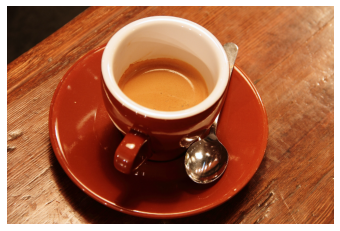

In [2]:
im = skimage.data.coffee()
_ = show_image(im)

# Pre/post processing of image

Normalization, resizing etc... to correspond to the input format of images trained by t

In [3]:
# From D2L
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
#     img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [113]:
# Apply pre-proc to image
im_shape = (150, 225)
im_new = preprocess(im,im_shape)

# Get a pretrained model

In [5]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [6]:
pretrained_net.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Defined the image generator network and a function to make a partial pass through the network

In [114]:
class ImageGenerator(nn.Module):
    def __init__(self,shape):
        super(ImageGenerator,self).__init__()
        self.im = nn.Parameter(torch.rand(1, 3, *shape))
    def forward(self):
        return self.im

In [115]:
# Apply layer by layer mods
def partial_forward(input_im,n_layer):
    X = input_im
    for il in range(n_layer):
        X = pretrained_net.features[il](X)
    return X

def visu_im_rep(X, ncol=5):
    nrow = int(np.ceil(n_channels/ncol))
    fig, ax = plt.subplots(nrow,ncol,figsize=[15,24],tight_layout=True)
    with torch.no_grad():
        for ic in range(n_channels):
            plt.sca(ax[np.unravel_index(ic,(nrow,ncol))])
            show_image(X[0,ic,:,:])

`x` is the representation of our input image by the given layer. This representation is composed of many channels, each the result of a specific convolution that has been optimized through training to extract specific useful features. 
Now, we instantiate the simple ImageGenerator. `im_gen` parameters' (`list(im_gen.parameters())[0]`) contains a tensor initialized with random noise. 

In [9]:
len(pretrained_net.features)

37

# Define the content loss, including total variation regularization

In [120]:
def MSE_TV_loss(y_hat,y_ref,im):
    # y: filtered representation of content image on the given layer of the NN
    # y_hat: same as y for generated image
    # im: the generated image
    
    beta = 1. # Can be between 1 and 2
    H = im.shape[2]
    W = im.shape[3]
    C = im.shape[1]
    sigma = torch.sqrt(torch.sum(im**2))/H/W/C
    B = 1. # because images are standardized
    a = 0.01 # 1%
    Lambda_b = sigma**beta / (H*W*(a*B)**beta)# There is a better definition in the paper

    
    # MSE
    loss = torch.mean((y_hat-y_ref)**2)
    
    # total variation
    d_dx = im[:,:,1:,:]-im[:,:,:-1,:]
    d_dy = im[:,:,:,1:]-im[:,:,:,:-1]
    d_dx = .5*(d_dx[:,:,:,1:]+d_dx[:,:,:,:-1])
    d_dy = .5*(d_dy[:,:,1:,:]+d_dy[:,:,:-1,:])
    TV = torch.sum((d_dx**2+d_dy**2)**(beta/2.))
#     print(f"MSE: {loss:.2e}, TV: {TV:.2e}, $\\lambda$ TV: {Lambda_b*TV:.2e}")
    loss += Lambda_b*TV
    return loss

# Initialize the model

In [127]:
im_gen = ImageGenerator(im_shape)
current_im = list(im_gen.parameters())[0]
# preprocess(current_im,im_shape).shape
layer = 5

target_rep = partial_forward(preprocess(im,im_shape), layer)
loss_fn = MSE_TV_loss
optim = torch.optim.LBFGS(im_gen.parameters())
# Stopping criterion
abs_loss_limit = 1e-2
rel_loss_limit = 1e-4

In [128]:
# train
def closure():
#     if torch.is_grad_enabled():
    
    optim.zero_grad()
    im_rep = partial_forward(im_gen(), layer)
    loss = loss_fn(im_rep,target_rep.detach(), im_generated)
    loss.backward()
    return loss

last_loss = 1e10
for i in range(1000):    
    optim.step(closure)
    if i%1==0:
        with torch.no_grad():
            im_generated = list(im_gen.parameters())[0]
            im_rep = partial_forward(im_gen(), layer)
            loss = loss_fn(im_rep,target_rep.detach(), im_generated)
            print(f"epoch {i:02d}, loss: {loss:.10e}")
            if loss<abs_loss_limit:
                print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
                break
            if torch.abs(last_loss-loss)<1e-4:
                print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
                break
            last_loss = loss

epoch 00, loss: 6.7455315590e-01
epoch 01, loss: 2.9586052895e-01
epoch 02, loss: 2.4782472849e-01
epoch 03, loss: 2.1244233847e-01
epoch 04, loss: 1.9156980515e-01
epoch 05, loss: 1.8633812666e-01
epoch 06, loss: 1.8447995186e-01
epoch 07, loss: 1.8318025768e-01
epoch 08, loss: 1.8251524866e-01
epoch 09, loss: 1.8211331964e-01
epoch 10, loss: 1.8189907074e-01
epoch 11, loss: 1.8176354468e-01
epoch 12, loss: 1.8167632818e-01
stopped because relative loss limit (1.0e-04)  was reached


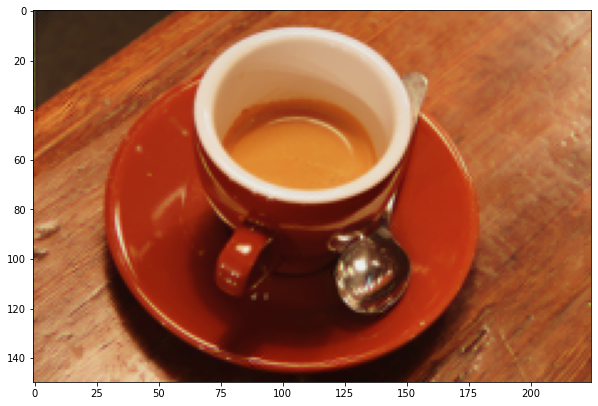

In [129]:
current_im = list(im_gen.parameters())[0][0]
fig, ax = plt.subplots(1,1,figsize=[10,10])
imnew = postprocess(current_im)
plt.imshow(imnew)

In [82]:
im_generated = list(im_gen.parameters())[0]
im_generated.shape

torch.Size([1, 3, 150, 225])